<a href="https://colab.research.google.com/github/SamuelK87/Detecting-COVID-19-Pneumonia-SARS-Streptococcus-in-X-ray-images/blob/master/Detect_COVID19_and_other_lung_disease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

[INFO] loading images...
[INFO] compiling model...
[INFO] training head...
Epoch 1/200
19/19 [==============================] - 4s 188ms/step - loss: 1.5056 - accuracy: 0.3555 - val_loss: 1.2124 - val_accuracy: 0.5283
Epoch 2/200
19/19 [==============================] - 3s 173ms/step - loss: 1.2819 - accuracy: 0.4252 - val_loss: 1.1136 - val_accuracy: 0.6509
Epoch 3/200
19/19 [==============================] - 3s 170ms/step - loss: 1.2196 - accuracy: 0.4718 - val_loss: 1.0502 - val_accuracy: 0.8019
Epoch 4/200
19/19 [==============================] - 3s 168ms/step - loss: 1.0734 - accuracy: 0.6480 - val_loss: 0.9713 - val_accuracy: 0.7925
Epoch 5/200
19/19 [==============================] - 3s 166ms/step - loss: 1.0496 - accuracy: 0.6174 - val_loss: 0.9153 - val_accuracy: 0.7830
Epoch 6/200
19/19 [==============================] - 3s 168ms/step - loss: 1.0133 - accuracy: 0.6545 - val_loss: 0.8593 - val_accuracy: 0.8302
Epoch 7/200
19/19 [==============================] - 3s 170ms/step 

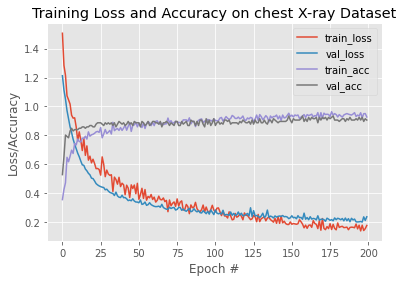

In [ ]:
# USAGE
# python train_TFl.py --dataset dataset

# USAGE
# python train.py --dataset dataset  --labelbin lb.pickle

# import the necessary packages
from keras.preprocessing.image import ImageDataGenerator
from keras.applications import VGG16
#from keras.applications.resnet50 import ResNet50
from keras.layers import AveragePooling2D
from keras.layers import Dropout
from keras.layers import Flatten
from keras.layers import Dense
from keras.layers import Input
from keras.models import Model
from keras.optimizers import Adam
from keras.utils import to_categorical
from sklearn.preprocessing import LabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from imutils import paths
import matplotlib.pyplot as plt
import numpy as np
import pickle
import argparse
import cv2
import os

# construct the argument parser and parse the arguments
#ap = argparse.ArgumentParser()
#ap.add_argument("-d", "--dataset", required=True,
#	help="path to input dataset")
#ap.add_argument("-p", "--plot", type=str, default="plot.png",
#	help="path to output loss/accuracy plot")
#ap.add_argument("-m", "--model", type=str, default="covid19.model",
#	help="path to output loss/accuracy plot")
#ap.add_argument("-l", "--labelbin", type=str,default="lb.pickle",
#	help="path to output label binarizer")
#args = vars(ap.parse_args())

# initialize the initial learning rate, number of epochs to train for,
# and batch size
INIT_LR = 1e-3
EPOCHS = 200
BS = 16

# grab the list of images in our dataset directory, then initialize
# the list of data (i.e., images) and class images
print("[INFO] loading images...")
imagePaths = sorted(list(paths.list_images('/content/drive/My Drive/Colab Notebooks/covid5cls')))
#imagePaths = list(paths.list_images(args["dataset"]))
data = []
labels = []

# loop over the image paths
for imagePath in imagePaths:
	# extract the class label from the filename
	label = imagePath.split(os.path.sep)[-2]

	# load the image, swap color channels, and resize it to be a fixed
	# 224x224 pixels while ignoring aspect ratio
	image = cv2.imread(imagePath)
	image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
	image = cv2.resize(image, (224, 224))

	# update the data and labels lists, respectively
	data.append(image)
	labels.append(label)

# convert the data and labels to NumPy arrays while scaling the pixel
# intensities to the range [0, 255]
data = np.array(data) / 255.0
labels = np.array(labels)

# perform one-hot encoding on the labels
lb = LabelBinarizer()
labels = lb.fit_transform(labels)
#labels = to_categorical(labels)

# partition the data into training and testing splits using 80% of
# the data for training and the remaining 20% for testing
(trainX, testX, trainY, testY) = train_test_split(data, labels,
	test_size=0.25, stratify=labels, random_state=42)

# account for skew in the labeled data
classTotals = trainY.sum(axis=0)
classWeight = classTotals.max() / classTotals

# initialize the training data augmentation object
trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

# load the VGG16 network, ensuring the head FC layer sets are left
# off
baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))

# construct the head of the model that will be placed on top of the
# the base model
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(5, activation="softmax")(headModel)

# place the head FC model on top of the base model (this will become
# the actual model we will train)
model = Model(inputs=baseModel.input, outputs=headModel)

# loop over all layers in the base model and freeze them so they will
# *not* be updated during the first training process
for layer in baseModel.layers:
	layer.trainable = False

# compile our model
print("[INFO] compiling model...")
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,
	metrics=["accuracy"])

# train the head of the network
print("[INFO] training head...")
H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
	validation_data=(testX, testY),
	validation_steps=len(testX) // BS,
	epochs=EPOCHS, class_weight=classWeight)

# make predictions on the testing set
print("[INFO] evaluating network...")
predIdxs = model.predict(testX, batch_size=BS)

# for each image in the testing set we need to find the index of the
# label with corresponding largest predicted probability
predIdxs = np.argmax(predIdxs, axis=1)

# show a nicely formatted classification report
print(classification_report(testY.argmax(axis=1), predIdxs,
	target_names=lb.classes_))

# compute the confusion matrix and and use it to derive the raw
# accuracy, sensitivity, and specificity
cm = confusion_matrix(testY.argmax(axis=1), predIdxs)
total = sum(sum(cm))
acc = (cm[0, 0] + cm[1, 1]) / total
sensitivity = cm[0, 0] / (cm[0, 0] + cm[0, 1])
specificity = cm[1, 1] / (cm[1, 0] + cm[1, 1])

# show the confusion matrix, accuracy, sensitivity, and specificity
print(cm)
print("acc: {:.4f}".format(acc))
print("sensitivity: {:.4f}".format(sensitivity))
print("specificity: {:.4f}".format(specificity))

# serialize the model to disk
print("[INFO] saving COVID-19 detector model...")
#model.save(args["model"], save_format="h5")
model.save('/content/drive/My Drive/Colab Notebooks/Results/COVID19/5Class/covid19.model')

# save the label binarizer to disk
print("[INFO] serializing label binarizer...")
f = open('/content/drive/My Drive/Colab Notebooks/Results/COVID19/5Class/lb_5cls.pickle', "wb")
f.write(pickle.dumps(lb))
f.close()

# plot the training loss and accuracy
N = EPOCHS
plt.style.use("ggplot")
plt.figure()
plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy on chest X-ray Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="upper right")
plt.savefig('/content/drive/My Drive/Colab Notebooks/Results/COVID19/5Class/plot.png', dpi=300)

# serialize the model to disk
#print("[INFO] saving COVID-19 detector model...")
#model.save(args["model"], save_format="h5")